In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOVIR as HALOVI
from complementary_models import HALOVAER as HALOVAE
import scanpy as sc
import scvi
import pandas as pd
# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [2]:
### test whole data with RNA only 
adata_multi = sc.read_h5ad("halo/E18_mouse_Brain/multiomic.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)

df_meta= pd.read_csv("halo/E18_mouse_Brain/RNA/metadata.tsv",sep = "\t",index_col=0)
bins = df_meta.binned.unique()
times = {}
index = 0
for bin in sorted(bins):
    times[bin] = index
    index += 1

def add_time(row, times):
    timestamp = times[row.binned]
    return timestamp

df_meta['time_key'] = df_meta.apply(lambda row: add_time(row, times), axis=1)

newindex = []

for idx, row in df_meta.iterrows():
    newindex.append(idx+"_paired")

df_meta['Id'] = newindex    

df_meta_sub = df_meta[["Id", 'latent_time']]

df_meta_sub.set_index("Id", inplace=True)
adata_mvi.obs = adata_mvi.obs.join(df_meta_sub, how="inner")
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [3]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 0 in adata.obs['_scvi_time_label'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


n_genes :14583


In [5]:
model.train(use_gpu=True, max_epochs=10)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=10 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [00:22<00:00,  2.29s/it, loss=1.02e+04, v_num=1]


In [8]:
model.save("model_RNA", overwrite=True)

In [4]:
model.load("model_RNA", adata_mvi)

INFO     File model_RNA/model.pt already downloaded                                          


/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 0 in adata.obs['_scvi_time_label'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


n_genes :14583


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [7]:

result = model.get_latent_representation()
result.shape

(3365, 10)

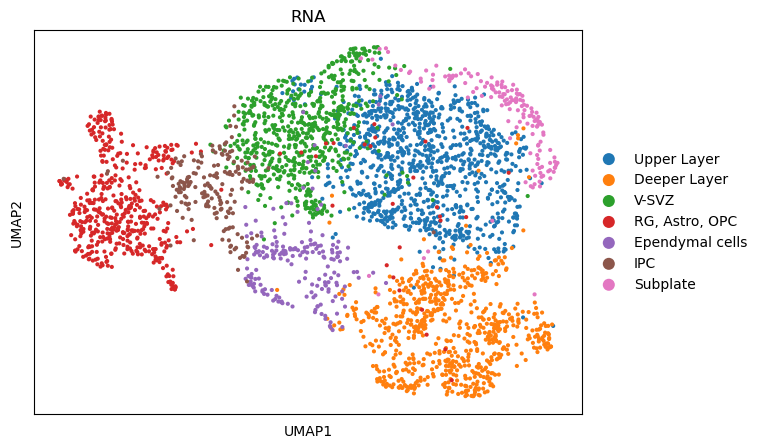

In [9]:
import matplotlib.pyplot as plt
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='celltype',basis='umap',
             title = 'RNA')
plt.show()

In [9]:
from complementary_models.infer_nonsta_dir import infer_nonsta_dir
from complementary_models import torch_infer_nonsta_dir
score1, _, _ = torch_infer_nonsta_dir(torch.tensor(latent_atac_dep).to('cuda'), torch.tensor(latent_expr_dep).to('cuda'), torch.tensor(times).to('cuda'))
score1

tensor(0.0002, device='cuda:0', dtype=torch.float64)

In [25]:
score2, _, _= torch_infer_nonsta_dir(torch.tensor(latent_expr_dep).to('cuda'), torch.tensor(latent_atac_dep).to('cuda'), torch.tensor(times).to('cuda'))
score2

/tmp/ipykernel_9657/715659028.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score2, _, _= torch_infer_nonsta_dir(torch.tensor(latent_expr_dep).to('cuda'), torch.tensor(latent_atac_dep).to('cuda'), torch.tensor(times).to('cuda'))


tensor(0.0002, device='cuda:0', dtype=torch.float64)

In [26]:
latent_atac_indep = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

score3, _, _ = torch_infer_nonsta_dir(latent_atac_indep, latent_expr_indep, times)
score3

/tmp/ipykernel_9657/4099870331.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_atac_indep = torch.tensor(latent_atac_indep).to('cuda')
/tmp/ipykernel_9657/4099870331.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_expr_indep = torch.tensor(latent_expr_indep).to('cuda')
/tmp/ipykernel_9657/4099870331.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times = torch.tensor(times).to('cuda')


tensor(0.0002, device='cuda:0', dtype=torch.float64)

In [27]:
score4, _, _ = torch_infer_nonsta_dir(latent_expr_indep, latent_atac_indep, times)
score4

tensor(0.0002, device='cuda:0', dtype=torch.float64)

In [28]:
score3 - score4

tensor(-1.1483e-05, device='cuda:0', dtype=torch.float64)

In [14]:
from numpy.linalg import inv
import pandas as pd

X = latent_atac
Y =  latent_expr

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.sum(np.abs(Y_Residual),axis=1)

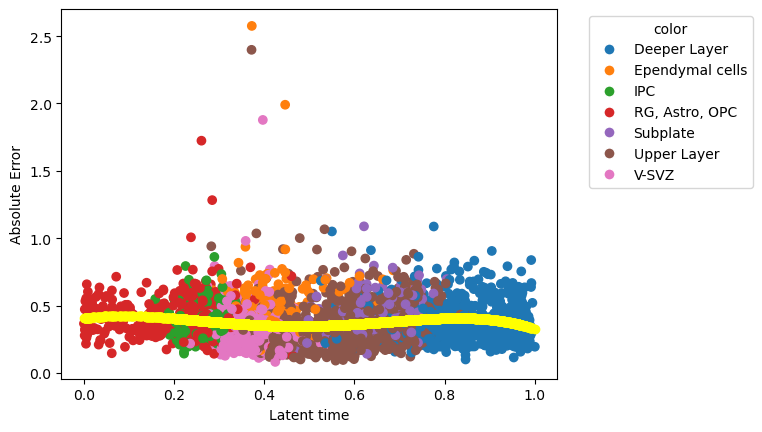

In [15]:
import tkinter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for legend handle


colors = {'Deeper Layer':'tab:blue', 'Ependymal cells':'tab:orange', 'IPC':'tab:green', 'RG, Astro, OPC':'tab:red', 
          'Subplate':'tab:purple', 'Upper Layer':'tab:brown', 'V-SVZ':'tab:pink'}

%matplotlib inline
plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


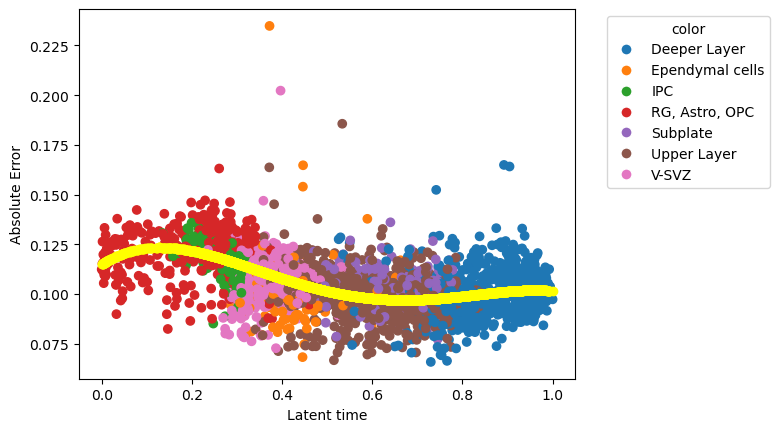

In [16]:
adata_RNA_sub  = adata_multi[:, adata_multi.var['feature_types'] == 'Gene Expression']
sc.pp.normalize_per_cell(adata_RNA_sub)
sc.pp.log1p(adata_RNA_sub)
Y = adata_RNA_sub.X.toarray()
X = latent_atac

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.mean(np.abs(Y_Residual),axis=1)


colors = {'Deeper Layer':'tab:blue', 'Ependymal cells':'tab:orange', 'IPC':'tab:green', 'RG, Astro, OPC':'tab:red', 
          'Subplate':'tab:purple', 'Upper Layer':'tab:brown', 'V-SVZ':'tab:pink'}

%matplotlib inline
plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

(3365, 5)


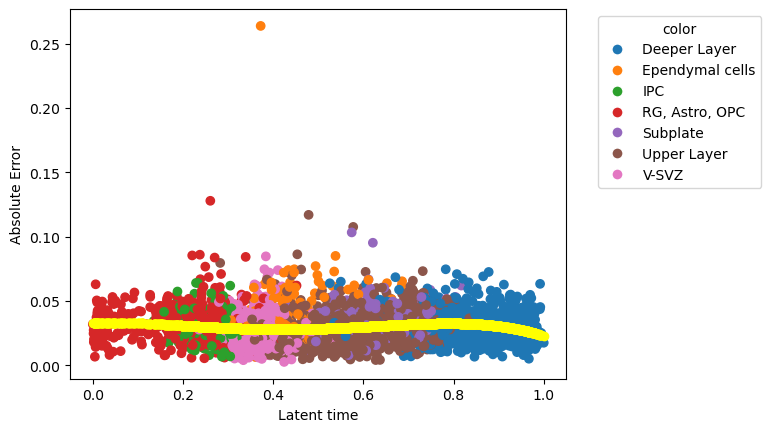

In [37]:
X = latent_atac_dep

Y =  latent_expr_dep
# Y = adata_RNA_sub.X.toarray()

print(X.shape)

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual_dep = np.mean(np.abs(Y_Residual),axis=1)


plt.scatter(df_meta['latent_time'], Y_Residual_dep, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual_dep, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

(3365, 5)
(3365, 5)


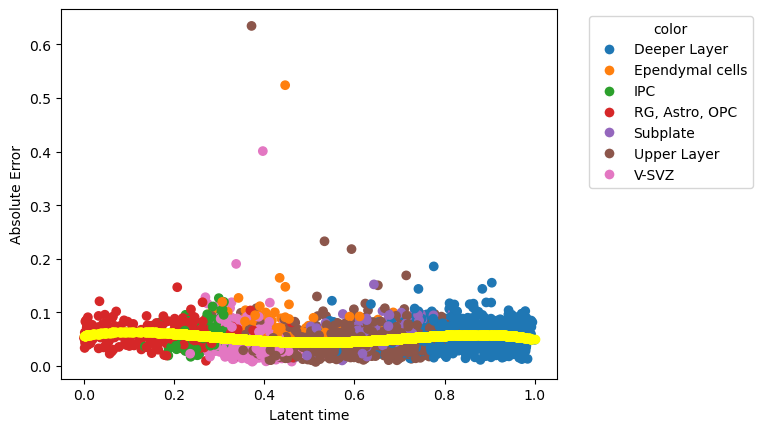

In [38]:
X = latent_atac_indep.to('cpu').detach().numpy()
Y =  latent_expr_indep.to('cpu').detach().numpy()
# Y = adata_RNA_sub.X.toarray()


print(X.shape)
print(Y.shape)


b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.mean(np.abs(Y_Residual),axis=1)


plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')

# plt.scatter(df_meta['latent_time'], Y_Residual_dep, color=df_meta['celltype'].map(colors))


# z = np.polyfit(df_meta['latent_time'], Y_Residual_dep, 4)
# p = np.poly1d(z)
# plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='green')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()